# Create Logistic Regressions using Previously Derived Current and Future Climate Training Data (UNBALANCED)
## Logistic regressions are also evaluated using various metrics and testing data.
## Visualizations of evaluation also contained herein.
### This notebook uses balanced test data. Another notebook contains unbalanced test data.

Import relevant packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Various functions that contain visualizations and metrics follow.

In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    
    #Plot routines for heatmap taken from:
    #https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
    
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=12)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticklabels(row_labels, fontsize=12)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im,
                     data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    
    """
    This function annotates created heatmap. 
    Logistic regression coefficients will be overlaid.
    
    """

    import matplotlib 
    
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    threshold = 0.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] < threshold:
                kw.update(color=textcolors[0])
            if data[i, j] >= threshold:
                kw.update(color=textcolors[1])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


#non-probabilistic forecasts for discrete predictands
#all referenced from Wilks - Chap 8, Forecast Verification, "Statistical Methods in the Atmospheric Sciences"

def threat_score(cont_matrix):
    
    """
    Threat score (Gilbert 1884) or critical success index 
    Worst score is zero, best score is one
    Wilks: "Proportion correct for the quantity being forecast after removing correct no forecasts from consideration"
    """    
    return np.divide(cont_matrix[0][0],cont_matrix[0][0]+cont_matrix[0][1]+cont_matrix[1][0])


def proportion_correct(cont_matrix):
    
    """
    Proportion correct (Finley 1884)
    """
    return np.divide(cont_matrix[0][0]+cont_matrix[1][1],cont_matrix[0][0]+cont_matrix[0][1]+cont_matrix[1][0]+cont_matrix[1][1])


def bias(cont_matrix):
    
    """
    Bias ratio
    Unbiased = 1, Bias > 1 means overforecasting, Bias < 1 means underforecasting
    """
    return np.divide(cont_matrix[0][0]+cont_matrix[0][1],cont_matrix[0][0]+cont_matrix[1][0])


def false_alarm_ratio(cont_matrix):
    
    """
    Fraction of yes forecasts that turned out to be wrong (Doswell et al. 1990)
    Best FAR is zero, worst is 1
    """
    return np.divide(cont_matrix[0][1],cont_matrix[0][0]+cont_matrix[0][1])


def hit_rate(cont_matrix):
    
    """
    also called the POD - probability of detection (Doswell et al. 1990)
    ratio of correct forecasts to the number of times the event occurred
    

    """
    return np.divide(cont_matrix[0][0],cont_matrix[0][0]+cont_matrix[1][0])


def false_alarm_rate(cont_matrix):
    
    """
    also known as the probability of false detection (POFD)
    ratio of false alarms to the total number of nonoccurrences of the event
    """
    return np.divide(cont_matrix[0][1],cont_matrix[0][1]+cont_matrix[1][1])


#Probabilistic forecasts for dichotomous predictands

    #Answers the question: What is the ability of the forecast to discriminate between events and non-events?
    #ROC: Perfect: Curve travels from bottom left to top left of diagram, then across to top right of diagram. Diagonal line indicates no skill.
    #ROC area:  Range: 0 to 1, 0.5 indicates no skill. Perfect score: 1

def brier_score(observations, forecasts):
    #from David John Gagne's DeepSky
    """
    Brier score 
    Squared error of the probability forecasts
    Basically the same as mean squared error
    perfect forecast = 0 (BS), BS=1 are bad forecasts
    
    Answers the question: What is the magnitude of the probability forecast errors?
    Measures the mean squared probability error. Murphy (1973) showed that it could be partitioned into 
    three terms: (1) reliability, (2) resolution, and (3) uncertainty.
    Range: 0 to 1.  Perfect score: 0. (https://www.cawcr.gov.au/projects/verification/)
    """
    return np.mean((forecasts - observations) ** 2)


def brier_skill_score(observations, forecasts):
    #from David John Gagne's DeepSky
    
    """
    Answers the question: What is the relative skill of the probabilistic forecast over that of climatology, 
    in terms of predicting whether or not an event occurred?
    Range: -∞ to 1, 0 indicates no skill when compared to the reference forecast. Perfect score: 1.
    (https://www.cawcr.gov.au/projects/verification/)
    """
    bs_climo = brier_score(observations, observations.mean())
    bs = brier_score(observations, forecasts)
    return 1.0 - bs / bs_climo


def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    

#calculate skill scores - brier decomposition (reliability and resolution and uncertainty) likely bad if non balanced test data


def brier_score_components(observations, forecasts):
    obs_truth = observations
    climo_freq = obs_truth.sum() / float(obs_truth.size)
    total_freq = self.total_relative_frequency * self.forecasts.size   ####DONT UNDERSTAND  [self.total_relative_frequency = np.zeros(self.thresholds.shape)]
    bins = 0.5 * (self.thresholds[0:-1] + self.thresholds[1:])  ####DONT UNDERSTAND
    pos_rel_freq = np.where(np.isnan(self.pos_relative_frequency), 0, self.pos_relative_frequency)  ####DONT UNDERSTAND
    reliability = np.mean(total_freq * (bins - pos_rel_freq) ** 2)
    resolution = np.mean(total_freq * (pos_rel_freq - climo_freq) ** 2)
    uncertainty = climo_freq * (1 - climo_freq)
    return reliability, resolution, uncertainty


# self.pos_relative_frequency[t] = pos_frequency[t] / float(total_frequency[t])              
# self.total_relative_frequency[t] = total_frequency / self.forecasts.

Import data sets that will be used in training and testing.

In [3]:
#these are the mean values for each storm patch
data_mean_current = xr.open_dataset(f"/glade/scratch/molina/WRF_CONUS1_derived/logistic_regression/current_meanpatch_traintestdata_unbalanced.nc")
data_mean_futures = xr.open_dataset(f"/glade/scratch/molina/WRF_CONUS1_derived/logistic_regression/future_meanpatch_traintestdata_unbalanced.nc")

#these are the values at locations of max UH for each storm patch
data_varsatmaxUH = xr.open_dataset("/glade/scratch/molina/WRF_CONUS1_derived/logistic_regression/varsatUHmax_traintestdata_unbalanced.nc")

Each dataset contains training and testing data. For example:

In [4]:
data_mean_current

<xarray.Dataset>
Dimensions:        (a: 39940, b: 548339, features: 20)
Coordinates:
    feature        (features) object ...
Dimensions without coordinates: a, b, features
Data variables:
    X_train        (a, features) float32 ...
    X_train_label  (a) float64 ...
    X_test         (b, features) float32 ...
    X_test_label   (b) float64 ...

Training data has 20 features that will be used with previously applied dimensionality reduction based on method chosen (e.g., mean or max at UH). These are state variables that were interpolated on height above ground level (AGL). The heights are 1, 3, 5, and 7-km.

In [5]:
data_mean_futures.feature.values

array(['tk_1km', 'tk_3km', 'tk_5km', 'tk_7km', 'ev_1km', 'ev_3km',
       'ev_5km', 'ev_7km', 'eu_1km', 'eu_3km', 'eu_5km', 'eu_7km',
       'pr_1km', 'pr_3km', 'pr_5km', 'pr_7km', 'qv_1km', 'qv_3km',
       'qv_5km', 'qv_7km'], dtype=object)

Now, train the logistic regression using the mean data (storm patches) for the current climate simulations. Various skill scores using current climate balanced test data of both storm patch classes follow the training.

In [93]:
#LOGISTIC REGRESSION USING CURRENT TRAINING AND CURRENT TEST

lr_currentclim_l2 = LogisticRegression(max_iter=10000, C=2.0,
                                    solver='lbfgs', penalty='l2',
                                    n_jobs=36)

lr_currentclim_l2.fit(data_mean_current.dropna(dim='a').X_train, data_mean_current.dropna(dim='a').X_train_label)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Create a 2x2 contingency matrix and evaluate scalar attributes of the 2x2 contingency table

In [94]:
contigency_matr = contingency_matrix(labels_true=data_mean_current.dropna(dim='b').X_test_label, 
                                     labels_pred=lr_currentclim_l2.predict(data_mean_current.dropna(dim='b').X_test))

print("Proportion Correct: ", proportion_correct(contigency_matr))
print("Threat Score: ", threat_score(contigency_matr))
print("Bias: ", bias(contigency_matr))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr))
print("Hit Rate: ", hit_rate(contigency_matr))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr))

print("Brier Score: ", brier_score(observations = data_mean_current.dropna(dim='b').X_test_label.values, 
                                   forecasts = lr_currentclim_l2.predict(data_mean_current.dropna(dim='b').X_test)))

print("Brier Skill Score: ", brier_skill_score(observations = data_mean_current.dropna(dim='b').X_test_label.values, 
                                               forecasts = lr_currentclim_l2.predict(data_mean_current.dropna(dim='b').X_test)))


print("AUC: ", roc_auc_score(data_mean_current.dropna(dim='b').X_test_label.values,
                             lr_currentclim_l2.predict_proba(data_mean_current.dropna(dim='b').X_test)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.9757303419964657
Threat Score:  0.9757291911736544
Bias:  0.975801259545535
False Alarm Ratio:  3.7381430774262886e-05
Hit Rate:  0.9757647826983018
False Alarm Rate:  0.43478260869565216
Brier Score:  0.02426965800353431
Brier Skill Score:  -0.02442295058969557
AUC:  0.8983769486174559


Visualize coefficients of trained logistic regression.

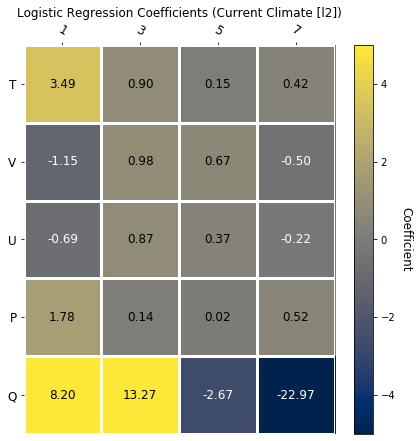

In [96]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Current Climate [l2])", fontsize=12)
im, cbar = heatmap(lr_currentclim_l2.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"], 
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

Now, train the logistic regression using the mean data (storm patches) for the current climate simulations using a different solver and penalty score (l1). Various skill scores using current climate balanced test data of both storm patch classes follow the training. Again, evaluate using various metrics and visualize coefficients.

In [101]:
#LOGISTIC REGRESSION USING CURRENT TRAINING AND CURRENT TEST

lr_currentclim_l1 = LogisticRegression(max_iter=10000, C=0.10,
                                    solver='saga', penalty='l1', 
                                    n_jobs=36)

lr_currentclim_l1.fit(data_mean_current.dropna(dim='a').X_train, data_mean_current.dropna(dim='a').X_train_label)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
contigency_matr_l1 = contingency_matrix(labels_true=data_mean_current.dropna(dim='b').X_test_label.values, 
                                        labels_pred=lr_currentclim_l1.predict(data_mean_current.dropna(dim='b').X_test))

print("Proportion Correct: ", proportion_correct(contigency_matr_l1))
print("Threat Score: ", threat_score(contigency_matr_l1))
print("Bias: ", bias(contigency_matr_l1))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr_l1))
print("Hit Rate: ", hit_rate(contigency_matr_l1))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr_l1))

print("Brier Score: ", brier_score(observations = data_mean_current.dropna(dim='b').X_test_label.values, 
                                   forecasts = lr_currentclim_l1.predict(data_mean_current.dropna(dim='b').X_test)))

print("Brier Skill Score: ", brier_skill_score(observations = data_mean_current.dropna(dim='b').X_test_label.values, 
                                               forecasts = lr_currentclim_l1.predict(data_mean_current.dropna(dim='b').X_test)))

print("AUC: ", roc_auc_score(data_mean_current.dropna(dim='b').X_test_label.values,
                             lr_currentclim_l1.predict_proba(data_mean_current.dropna(dim='b').X_test)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.8238699052958115
Threat Score:  0.820381298482952
Bias:  1.2056249352147714
False Alarm Ratio:  0.17553385355824494
Hit Rate:  0.9939969443906133
False Alarm Rate:  0.8981494764022379
Brier Score:  0.17613009470418847
Brier Skill Score:  -6.434456277802992
AUC:  0.8970322482996823


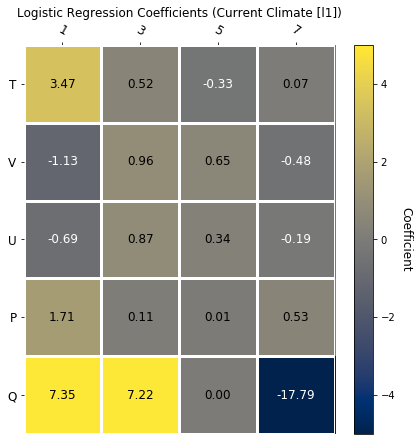

In [103]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Current Climate [l1])", fontsize=12)
im, cbar = heatmap(lr_currentclim_l1.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"], 
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

The use of different solvers and parameter optimizers did not result in much change in these scalar attributes of the contingency table or coefficients.

Now, let's move on to the future climate simulations. Train the logistic regression using the mean data (storm patches) for the future climate simulations. Various skill scores using future climate balanced test data of both storm patch classes follow the training.

In [108]:
#LOGISTIC REGRESSION USING FUTURE TRAINING AND FUTURE TEST

lr_futureclim_l2 = LogisticRegression(max_iter=10000, C=2.0,
                                   solver='lbfgs', penalty='l2',
                                   n_jobs=36)

lr_futureclim_l2.fit(data_mean_futures.X_train, data_mean_futures.X_train_label)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
contigency_matr_l2_future = contingency_matrix(labels_true=data_mean_futures.X_test_label, 
                                               labels_pred=lr_futureclim_l2.predict(data_mean_futures.X_test))

print("Proportion Correct: ", proportion_correct(contigency_matr_l2_future))
print("Threat Score: ", threat_score(contigency_matr_l2_future))
print("Bias: ", bias(contigency_matr_l2_future))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr_l2_future))
print("Hit Rate: ", hit_rate(contigency_matr_l2_future))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr_l2_future))

print("Brier Score: ", brier_score(observations = data_mean_futures.X_test_label.values, 
                                   forecasts = lr_futureclim_l2.predict(data_mean_futures.X_test)))

print("Brier Skill Score: ", brier_skill_score(observations = data_mean_futures.X_test_label.values, 
                                               forecasts = lr_futureclim_l2.predict(data_mean_futures.X_test)))

print("AUC: ", roc_auc_score(data_mean_futures.X_test_label.values,
                             lr_futureclim_l2.predict_proba(data_mean_futures.X_test)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.9684619532804069
Threat Score:  0.9683558364866415
Bias:  0.981269814934374
False Alarm Ratio:  0.006686025141512901
Hit Rate:  0.9747090202811151
False Alarm Rate:  0.6595358955765047
Brier Score:  0.031538046719593156
Brier Skill Score:  -0.14313765367607134
AUC:  0.8881269825667955


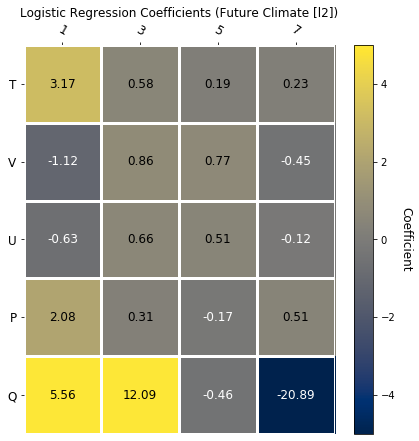

In [110]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Future Climate [l2])", fontsize=12)
im, cbar = heatmap(lr_futureclim_l2.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"],
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

Next, train the logistic regression using the mean data (storm patches) for the future climate simulations with a different solver and parameter optimizer. Various skill scores using future climate balanced test data of both storm patch classes follow the training.

In [121]:
#LOGISTIC REGRESSION USING FUTURE TRAINING AND FUTURE TEST

lr_futureclim_l1 = LogisticRegression(max_iter=10000, C=0.01,
                                      solver='saga', penalty='l1',
                                      n_jobs=36)

lr_futureclim_l1.fit(data_mean_futures.X_train, data_mean_futures.X_train_label)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [122]:
contigency_matr_l1_future = contingency_matrix(labels_true=data_mean_futures.X_test_label, 
                                               labels_pred=lr_futureclim_l1.predict(data_mean_futures.X_test))

print("Proportion Correct: ", proportion_correct(contigency_matr_l1_future))
print("Threat Score: ", threat_score(contigency_matr_l1_future))
print("Bias: ", bias(contigency_matr_l1_future))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr_l1_future))
print("Hit Rate: ", hit_rate(contigency_matr_l1_future))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr_l1_future))

print("Brier Score: ", brier_score(observations=data_mean_futures.X_test_label.values, 
                                   forecasts=lr_futureclim_l1.predict(data_mean_futures.X_test)))

print("Brier Skill Score: ", brier_skill_score(observations = data_mean_futures.X_test_label.values, 
                                               forecasts = lr_futureclim_l1.predict(data_mean_futures.X_test)))

print("AUC: ", roc_auc_score(data_mean_futures.X_test_label.values,
                             lr_futureclim_l1.predict_proba(data_mean_futures.X_test)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.028750656224219764
Threat Score:  0.0003657281482026024
Bias:  2734.2713567839196
False Alarm Ratio:  0.9996342718517974
Hit Rate:  1.0
False Alarm Rate:  0.9715945932910938
Brier Score:  0.9712493437757802
Brier Skill Score:  -34.204199735315505
AUC:  0.8762412189592705


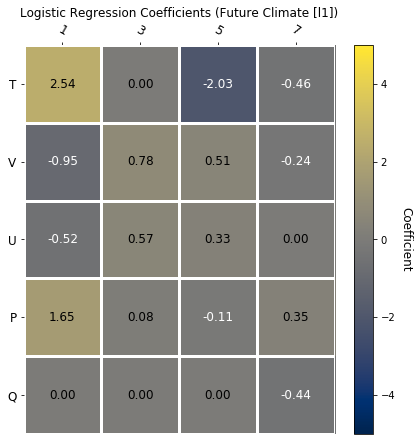

In [123]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Future Climate [l1])", fontsize=12)
im, cbar = heatmap(lr_futureclim_l1.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"],
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

Now, train the logistic regression using the data variables located at max UH locations (within storm patches) for the current climate simulations. Various skill scores using current climate balanced test data of both storm patch classes follow the training.

First, print out the data set contents for proper referencing of associated variables.

In [124]:
data_varsatmaxUH

<xarray.Dataset>
Dimensions:                (a: 39940, b: 548339, c: 47702, d: 560022, features: 20)
Coordinates:
    feature                (features) object ...
Dimensions without coordinates: a, b, c, d, features
Data variables:
    X_train_current        (a, features) float32 0.916849 ... -1.7484128
    X_train_current_label  (a) float64 1.0 1.0 1.0 0.0 1.0 ... 0.0 0.0 1.0 0.0
    X_test_current         (b, features) float32 -0.4930225 ... -1.129027
    X_test_current_label   (b) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    X_train_futures        (c, features) float32 -0.8571867 ... 2.1425257
    X_train_futures_label  (c) float64 1.0 0.0 1.0 0.0 1.0 ... 0.0 1.0 1.0 0.0
    X_test_futures         (d, features) float32 0.73516613 ... -0.760373
    X_test_futures_label   (d) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [125]:
#LOGISTIC REGRESSION USING CURRENT TRAINING AND CURRENT TEST for VARS AT MAX UH

lr_currentclim_l2_varsatmax = LogisticRegression(max_iter=10000, C=1.0,
                                                    solver='lbfgs', penalty='l2',
                                                    n_jobs=36)

lr_currentclim_l2_varsatmax.fit(data_varsatmaxUH.dropna(dim='a').X_train_current, data_varsatmaxUH.dropna(dim='a').X_train_current_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [126]:
contigency_matr = contingency_matrix(labels_true=data_varsatmaxUH.dropna(dim='b').X_train_current_label, 
                                     labels_pred=lr_currentclim_l2_varsatmax.predict(data_varsatmaxUH.dropna(dim='b').X_train_current))

print("Proportion Correct: ", proportion_correct(contigency_matr))
print("Threat Score: ", threat_score(contigency_matr))
print("Bias: ", bias(contigency_matr))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr))
print("Hit Rate: ", hit_rate(contigency_matr))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr))

print("Brier Score: ", brier_score(observations = data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                   forecasts = lr_currentclim_l2_varsatmax.predict(data_varsatmaxUH.dropna(dim='b').X_test_current)))

print("Brier Skill Score: ", brier_skill_score(observations = data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                               forecasts = lr_currentclim_l2_varsatmax.predict(data_varsatmaxUH.dropna(dim='b').X_test_current)))


print("AUC: ", roc_auc_score(data_varsatmaxUH.dropna(dim='b').X_test_current_label.values,
                             lr_currentclim_l2_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='b').X_test_current)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.9201802704056085
Threat Score:  0.8508468232431927
Bias:  1.0193976518631955
False Alarm Ratio:  0.08933400100150225
Hit Rate:  0.9283307810107198
False Alarm Rate:  0.08766584766584766
Brier Score:  0.09162232053952124
Brier Skill Score:  -2.867373863339019
AUC:  0.9734491980105355


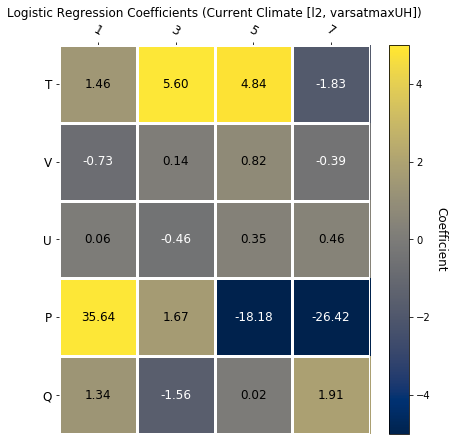

In [127]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Current Climate [l2, varsatmaxUH])", fontsize=12)
im, cbar = heatmap(lr_currentclim_l2_varsatmax.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"], 
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

Now, change the solver to ``saga`` and the penalty to ``l1``.

In [128]:
#LOGISTIC REGRESSION USING CURRENT TRAINING AND CURRENT TEST for VARS AT MAX UH

lr_currentclim_l1_varsatmax = LogisticRegression(max_iter=10000, C=1.0,
                                                    solver='saga', penalty='l1',
                                                    n_jobs=36)

lr_currentclim_l1_varsatmax.fit(data_varsatmaxUH.dropna(dim='a').X_train_current, data_varsatmaxUH.dropna(dim='a').X_train_current_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
contigency_matr = contingency_matrix(labels_true=data_varsatmaxUH.dropna(dim='b').X_train_current_label, 
                                     labels_pred=lr_currentclim_l1_varsatmax.predict(data_varsatmaxUH.dropna(dim='b').X_train_current))

print("Proportion Correct: ", proportion_correct(contigency_matr))
print("Threat Score: ", threat_score(contigency_matr))
print("Bias: ", bias(contigency_matr))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr))
print("Hit Rate: ", hit_rate(contigency_matr))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr))

print("Brier Score: ", brier_score(observations = data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                   forecasts = lr_currentclim_l1_varsatmax.predict(data_varsatmaxUH.dropna(dim='b').X_test_current)))

print("Brier Skill Score: ", brier_skill_score(observations = data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                               forecasts = lr_currentclim_l1_varsatmax.predict(data_varsatmaxUH.dropna(dim='b').X_test_current)))


print("AUC: ", roc_auc_score(data_varsatmaxUH.dropna(dim='b').X_test_current_label.values,
                             lr_currentclim_l1_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='b').X_test_current)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.9301952929394092
Threat Score:  0.8686887716654107
Bias:  1.013396934943672
False Alarm Ratio:  0.07641462193289934
Hit Rate:  0.9359585912919923
False Alarm Rate:  0.07541761391716913
Brier Score:  0.07943275862697825
Brier Skill Score:  -2.352853025310397
AUC:  0.9781497392169479


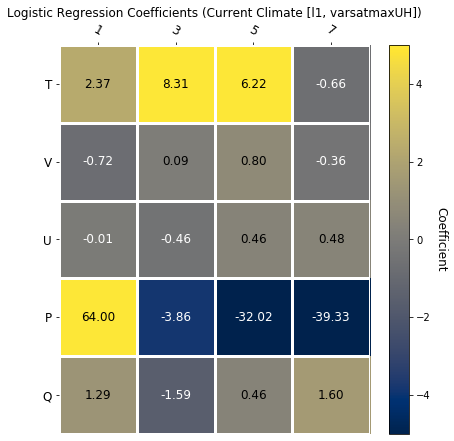

In [130]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Current Climate [l1, varsatmaxUH])", fontsize=12)
im, cbar = heatmap(lr_currentclim_l1_varsatmax.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"], 
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

Now, train the logistic regression using the data variables located at max UH locations (within storm patches) for the future climate simulations. Various skill scores using future climate balanced test data of both storm patch classes follow the training.

In [131]:
#LOGISTIC REGRESSION USING FUTURE TRAINING AND FUTURE TEST for VARS AT MAX UH

lr_futureclim_l2_varsatmax = LogisticRegression(max_iter=10000, C=1.0,
                                                    solver='lbfgs', penalty='l2',
                                                    n_jobs=36)

lr_futureclim_l2_varsatmax.fit(data_varsatmaxUH.dropna(dim='c').X_train_futures, data_varsatmaxUH.dropna(dim='c').X_train_futures_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
contigency_matr = contingency_matrix(labels_true=data_varsatmaxUH.X_train_futures_label, 
                                     labels_pred=lr_futureclim_l2_varsatmax.predict(data_varsatmaxUH.X_train_futures))

print("Proportion Correct: ", proportion_correct(contigency_matr))
print("Threat Score: ", threat_score(contigency_matr))
print("Bias: ", bias(contigency_matr))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr))
print("Hit Rate: ", hit_rate(contigency_matr))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr))

print("Brier Score: ", brier_score(observations = data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                   forecasts = lr_futureclim_l2_varsatmax.predict(data_varsatmaxUH.dropna(dim='d').X_test_futures)))

print("Brier Skill Score: ", brier_skill_score(observations = data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                               forecasts = lr_futureclim_l2_varsatmax.predict(data_varsatmaxUH.dropna(dim='d').X_test_futures)))


print("AUC: ", roc_auc_score(data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values,
                             lr_futureclim_l2_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='d').X_test_futures)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.9184520565175465
Threat Score:  0.8481891976272244
Bias:  1.0146339388267325
False Alarm Ratio:  0.08875938115802272
Hit Rate:  0.9245756583145446
False Alarm Rate:  0.08749741682165736
Brier Score:  0.08862540623549159
Brier Skill Score:  -2.212332349049727
AUC:  0.9727019625514408


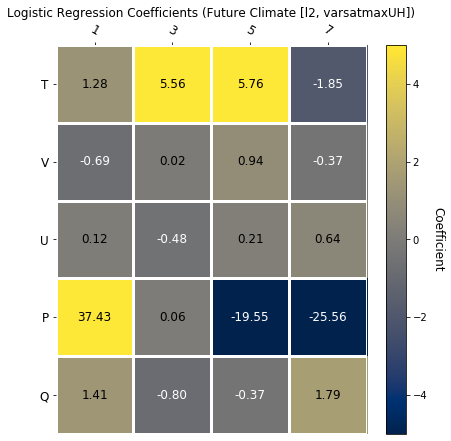

In [133]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Future Climate [l2, varsatmaxUH])", fontsize=12)
im, cbar = heatmap(lr_futureclim_l2_varsatmax.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"], 
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

Now, change the regression solver to ``saga`` and the penalty to ``l1``.

In [134]:
#LOGISTIC REGRESSION USING CURRENT TRAINING AND CURRENT TEST for VARS AT MAX UH

lr_futureclim_l1_varsatmax = LogisticRegression(max_iter=10000, C=1.0,
                                                    solver='saga', penalty='l1',
                                                    n_jobs=36)

lr_futureclim_l1_varsatmax.fit(data_varsatmaxUH.dropna(dim='c').X_train_futures, data_varsatmaxUH.dropna(dim='c').X_train_futures_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=36, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
contigency_matr = contingency_matrix(labels_true=data_varsatmaxUH.X_train_futures_label, 
                                     labels_pred=lr_futureclim_l1_varsatmax.predict(data_varsatmaxUH.X_train_futures))

print("Proportion Correct: ", proportion_correct(contigency_matr))
print("Threat Score: ", threat_score(contigency_matr))
print("Bias: ", bias(contigency_matr))
print("False Alarm Ratio: ", false_alarm_ratio(contigency_matr))
print("Hit Rate: ", hit_rate(contigency_matr))
print("False Alarm Rate: ", false_alarm_rate(contigency_matr))

print("Brier Score: ", brier_score(observations = data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                   forecasts = lr_futureclim_l1_varsatmax.predict(data_varsatmaxUH.dropna(dim='d').X_test_futures)))

print("Brier Skill Score: ", brier_skill_score(observations = data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                               forecasts = lr_futureclim_l1_varsatmax.predict(data_varsatmaxUH.dropna(dim='d').X_test_futures)))


print("AUC: ", roc_auc_score(data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values,
                             lr_futureclim_l1_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='d').X_test_futures)[:, 1] #prob of positive (1) class (UH>75)
                            ))

Proportion Correct:  0.9259569829357259
Threat Score:  0.8613542688910697
Bias:  1.0120507489285866
False Alarm Ratio:  0.0799966458429416
Hit Rate:  0.9310900835914626
False Alarm Rate:  0.0790553138595401
Brier Score:  0.07976500839255742
Brier Skill Score:  -1.8911767817547411
AUC:  0.9757915910306892


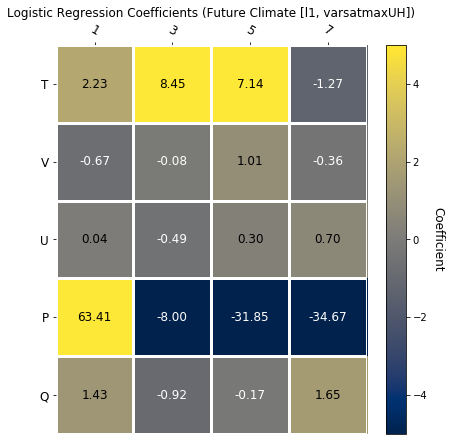

In [136]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_axes([0.0,0.0,0.9,0.9])

ax.set_title("Logistic Regression Coefficients (Future Climate [l1, varsatmaxUH])", fontsize=12)
im, cbar = heatmap(lr_futureclim_l1_varsatmax.coef_.reshape(5,4), 
                   row_labels=["T","V","U","P","Q"], 
                   col_labels=["1","3","5","7"], ax=ax,
                   cmap="cividis", cbarlabel="Coefficient", vmin=-5, vmax=5)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=12)

plt.show()

Now, evaluate the forecasts as probabilistic forecasts for all logistic regressions and corresponding climate simulation test data using a ROC diagram. 
After that, evaluate the logistic regressions using the opposite climate simulation test data to see if performance declines.

/glade/work/molina/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


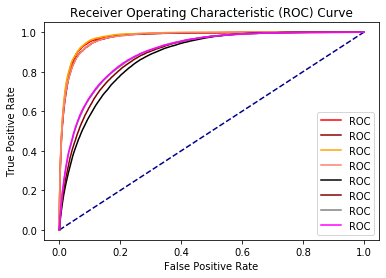

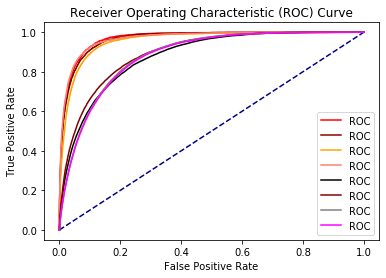

In [138]:
fpr1, tpr1, thresholds1 = roc_curve(data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                    
                                 lr_futureclim_l1_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='d').X_test_futures)[:, 1]) #(probability of > UH threshold of 75)

fpr2, tpr2, thresholds2 = roc_curve(data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                    
                                 lr_futureclim_l2_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='d').X_test_futures)[:, 1]) #(probability of > UH threshold of 75)

fpr3, tpr3, thresholds3 = roc_curve(data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                    
                                 lr_currentclim_l1_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='b').X_test_current)[:, 1]) #(probability of > UH threshold of 75)

fpr4, tpr4, thresholds4 = roc_curve(data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                    
                                 lr_currentclim_l2_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='b').X_test_current)[:, 1]) #(probability of > UH threshold of 75)

fpr5, tpr5, thresholds5 = roc_curve(data_mean_futures.X_test_label.values, 
                                    
                                 lr_futureclim_l1.predict_proba(data_mean_futures.X_test)[:, 1]) #(probability of > UH threshold of 75)

fpr6, tpr6, thresholds6 = roc_curve(data_mean_futures.X_test_label.values, 
                                    
                                 lr_futureclim_l2.predict_proba(data_mean_futures.X_test)[:, 1]) #(probability of > UH threshold of 75)

fpr7, tpr7, thresholds7 = roc_curve(data_mean_current.X_test_label.values, 
                                    
                                 lr_currentclim_l1.predict_proba(data_mean_current.X_test)[:, 1]) #(probability of > UH threshold of 75)

fpr8, tpr8, thresholds8 = roc_curve(data_mean_current.X_test_label.values, 
                                    
                                 lr_currentclim_l2.predict_proba(data_mean_current.X_test)[:, 1]) #(probability of > UH threshold of 75)




fpr10, tpr10, thresholds10 = roc_curve(data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                    
                                 lr_futureclim_l1_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='b').X_test_current)[:, 1]) #(probability of > UH threshold of 75)

fpr11, tpr11, thresholds11 = roc_curve(data_varsatmaxUH.dropna(dim='b').X_test_current_label.values, 
                                    
                                 lr_futureclim_l2_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='b').X_test_current)[:, 1]) #(probability of > UH threshold of 75)

fpr12, tpr12, thresholds12 = roc_curve(data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                    
                                 lr_currentclim_l1_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='d').X_test_futures)[:, 1]) #(probability of > UH threshold of 75)

fpr13, tpr13, thresholds13 = roc_curve(data_varsatmaxUH.dropna(dim='d').X_test_futures_label.values, 
                                    
                                 lr_currentclim_l2_varsatmax.predict_proba(data_varsatmaxUH.dropna(dim='d').X_test_futures)[:, 1]) #(probability of > UH threshold of 75)


fpr15, tpr15, thresholds15 = roc_curve(data_mean_current.X_test_label.values, 
                                    
                                 lr_futureclim_l1.predict_proba(data_mean_current.X_test)[:, 1]) #(probability of > UH threshold of 75)

fpr16, tpr16, thresholds16 = roc_curve(data_mean_current.X_test_label.values, 
                                    
                                 lr_futureclim_l2.predict_proba(data_mean_current.X_test)[:, 1]) #(probability of > UH threshold of 75)

fpr17, tpr17, thresholds17 = roc_curve(data_mean_futures.X_test_label.values, 
                                    
                                 lr_currentclim_l1.predict_proba(data_mean_futures.X_test)[:, 1]) #(probability of > UH threshold of 75)

fpr18, tpr18, thresholds18 = roc_curve(data_mean_futures.X_test_label.values, 
                                    
                                 lr_currentclim_l2.predict_proba(data_mean_futures.X_test)[:, 1]) #(probability of > UH threshold of 75)



def plot_multi_roc_curve(fpr_list, tpr_list):
    
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    colors = ["red", "darkred", "orange", "salmon", "k", "maroon", "grey", "magenta",
             "dodgerblue", "k", "blue", "navy", "purple", "green", "violet", "brown"]
    
    for col, fpr, tpr in zip(colors, fpr_list, tpr_list):
        plt.plot(fpr, tpr, color=col, label='ROC')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        
    plt.legend()
    plt.show()
        
        
#these are regressions tested with corresponding climate period
plot_multi_roc_curve([fpr1,fpr2,fpr3,fpr4,fpr5,fpr6,fpr7,fpr8], 
                     [tpr1,tpr2,tpr3,tpr4,tpr5,tpr6,tpr7,tpr8])
#these are regressions tested with opposite climate period
plot_multi_roc_curve([fpr10,fpr11,fpr12,fpr13,fpr15,fpr16,fpr17,fpr18], 
                     [tpr10,tpr11,tpr12,tpr13,tpr15,tpr16,tpr17,tpr18])

It appears that performance declines primarily when using mean storm patch data as opposed to the maximum UH location data. Data are state variables. Changing the climate data does not change performance.